##  분석 과제(22.08.09.화)

### 1. 의사결정나무

#### Q 콘크리트 강도를 예측하는 의사결정나무 모델을 만들고 predict method를 이용하여 예측값을 구하라.

#### 0. 패키지 불러오기

In [38]:
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 데이터 구성:Series, DataFrame
import pandas as pd
 
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
 
# export_graphviz: 나무 구조 생성 및 저장 
from sklearn.tree import export_graphviz
 
# graphviz : 나무 구조 시각화  (.dot 확장자 파일 불러오기 등)
import graphviz
 
# 데이터 분할: train, test
from sklearn.model_selection import train_test_split
 
# 예측/회귀 Decision Tree
from sklearn.tree import DecisionTreeRegressor
 
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

In [12]:
import os
os.environ["PATH"]+=os.pathsep+'C:/Program Files/Graphviz/bin/'

#### 1. 데이터 구성하기

In [13]:
df_raw = pd.read_csv('Concrete.csv',encoding='euc-kr')
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
#목표변수, 설명 변수 데이터 지정
df_raw_y = df_raw['strength']
df_raw_x = df_raw.drop('strength',axis=1,inplace=False)

- train과 test의 비율을 6:4로 나누어 진행(8개씩 총 1030개)

In [14]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y
, test_size = 0.4, random_state = 1234)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (618, 8)
train data Y size : (618,)
test data X size : (412, 8)
test data Y size : (412,)


- train 데이터 618건, test 데이터 412건

#### 2-1. 모델 생성

#### - 기본 옵션으로 모델 생성

In [15]:
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x,df_train_y)

# train 데이터 설명력
print('Score on training set: {:.3f}'.format(tree_uncustomized.score(df_train_x,df_train_y)))

# test 데이터 설명력
print('Score on test set: {:.3f}'.format(tree_uncustomized.score(df_test_x,df_test_y)))

Score on training set: 0.996
Score on test set: 0.790


- train의 설명력은 100프로 이고, test의 설명력은 79%로 나타났다.
- train에서 과적합이 일어남(일반화로 depth를 낮춰 test 설명력 높임 필요)

#### -현재 생성된 트리 모델의 옵션 확인

In [16]:
tree_uncustomized

DecisionTreeRegressor(random_state=1234)

#### 2-2. 모델 parameter 조정(min_samples_leaf)(p106)

#### - min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [17]:
# train 및  test 설명력 결과 저장
train_score = []; test_score = []

# min_samples_leaf : 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

# 결과 저장    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore']= test_score

In [33]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.996,0.790
1,2,0.978,0.783
2,3,0.959,0.786
3,4,0.943,0.796
4,5,0.934,0.811
5,6,0.920,0.810
6,7,0.909,0.799
7,8,0.900,0.792
8,9,0.877,0.817
9,10,0.868,0.816


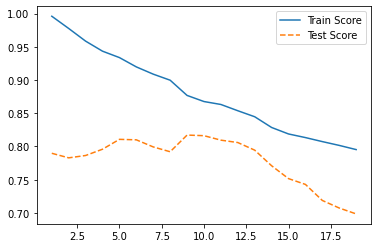

In [18]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_score,linestyle='-',label='Train Score')
plt.plot(para_leaf,test_score,linestyle='--',label='Test Score')
plt.legend()

- 잎사귀 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소하며 train과 test의 설명력 gap 차이가 작으면서 설명력이 높은 9 채택

#### 2-3. 모델 parameter 조정(나무구조 시각화)(p108)

#### - 나무구조 시각화 : graphviz

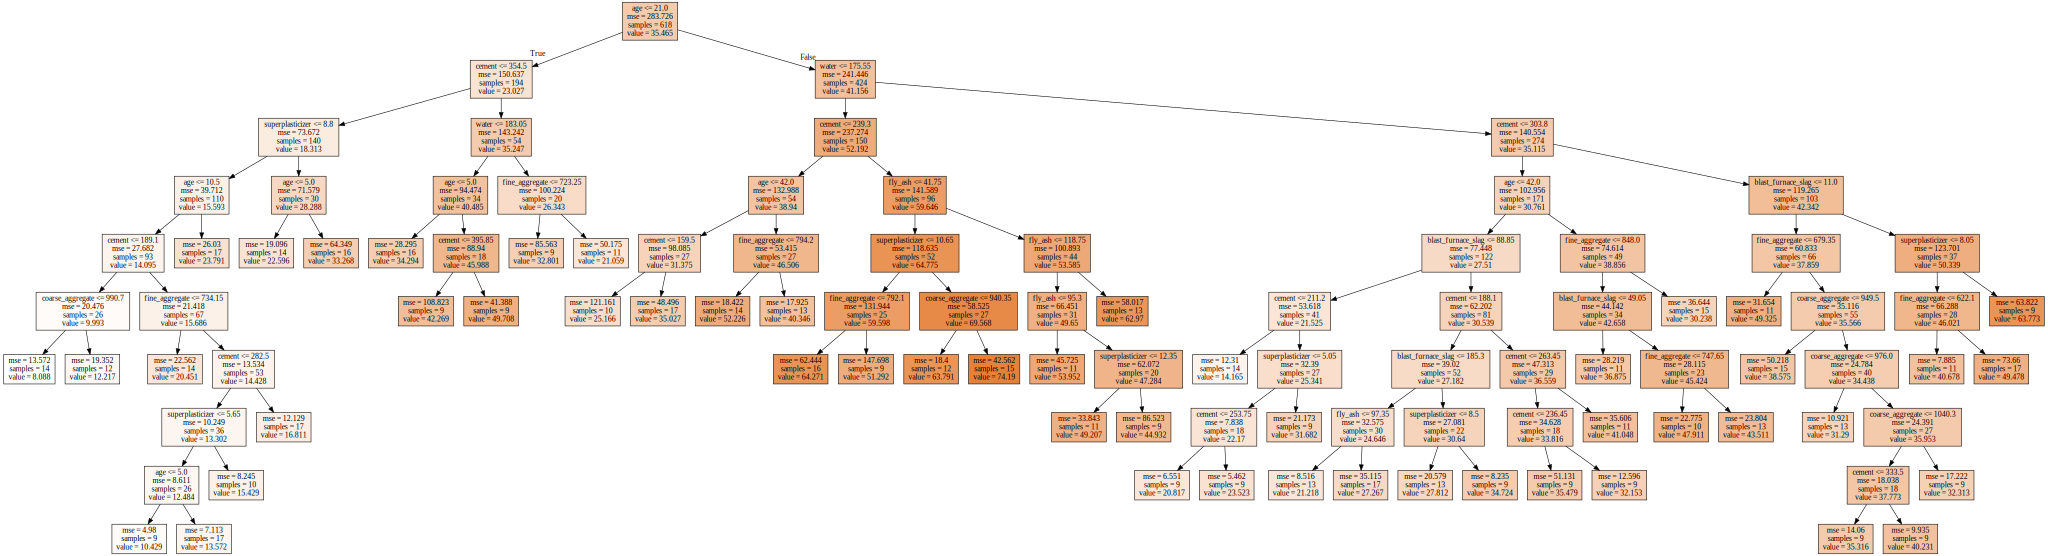

In [19]:
# 변수명 저장
v_feature_name = df_train_x.columns

# 노드의 최소 자료 수 = 8 모델
tree_graph = DecisionTreeRegressor(random_state=1234,min_samples_leaf=9)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph,out_file='tree_leaf.dot',feature_names=v_feature_name,impurity=True,filled=True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

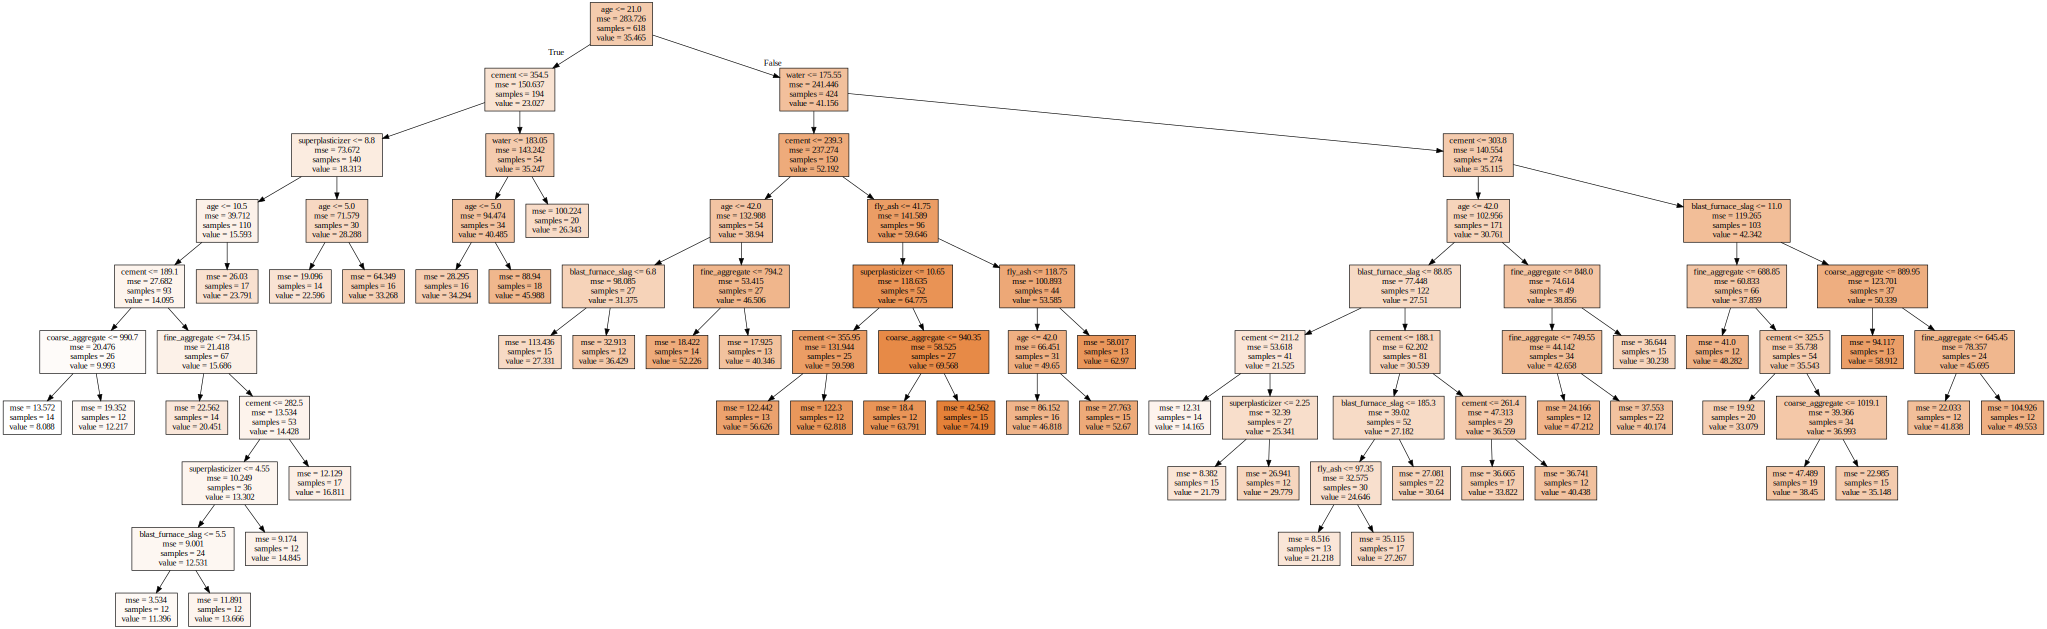

In [20]:
# 노드의 최소 자료 수 = 16 모델
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234,min_samples_leaf=12)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph,out_file='tree_leaf.dot',feature_names=v_feature_name,impurity=True,filled=True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

- 분리기준에서 MSE(squared error)값이 9일때의 경우 12일 때 보다 낮은값을 가져 좋은 모델이라 판단
- 자료 수 9가 균형적으로 분리

#### 2-4. 모델 parameter 조정(min_samples_split)(p110)

#### - min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [21]:
# train 및 test의 설명력 결과 저장
train_score = []; test_score = []

# min_samples_split : 분리 노드의 최소 자료 수 
para_split = [n_leaf * 2 for n_leaf in range(2,20)]
for v_min_samples_split in para_split:
    tree=DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=v_min_samples_split)
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

# 결과 저장
df_score_split=pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore']= test_score

In [22]:
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.900,0.792
1,6,0.900,0.792
2,8,0.900,0.792
3,10,0.900,0.792
4,12,0.900,0.792
5,14,0.900,0.792
6,16,0.900,0.792
7,18,0.887,0.798
8,20,0.882,0.802
9,22,0.874,0.802


#### 설명력은 train과 test의 gap차이를 고려하여 20,26일 경우로 판단

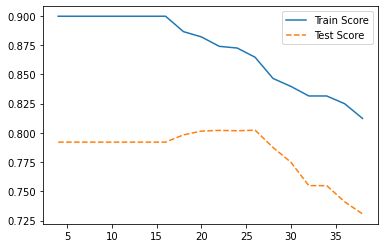

In [23]:
# 모델 설명력 그래프 확인
plt.plot(para_split,train_score,linestyle='-',label='Train Score')
plt.plot(para_split,test_score,linestyle='--',label='Test Score')
plt.legend()

- 20, 26 정도의 값이 유의미하다고 판단

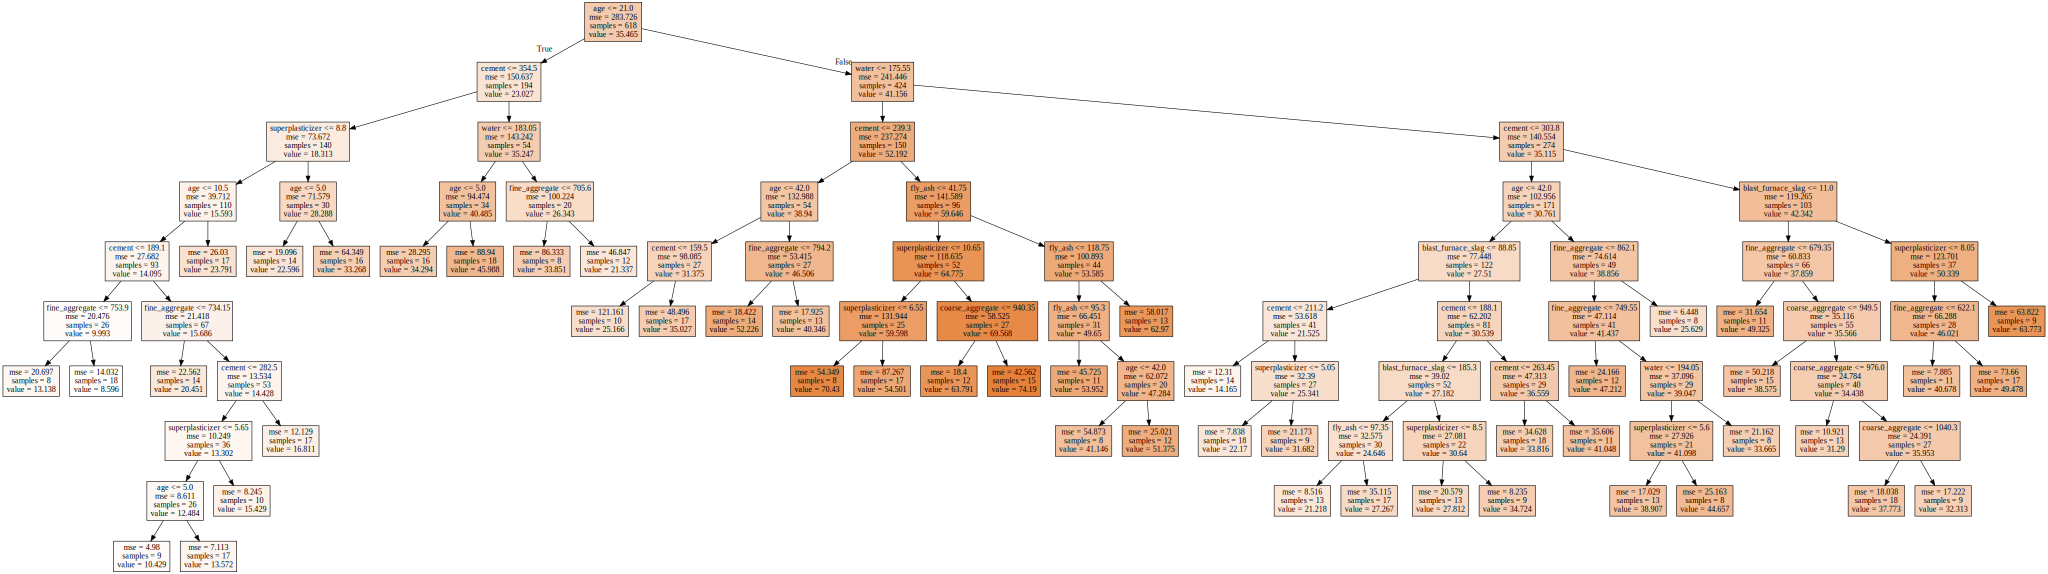

In [24]:
# 분리 노드의 최소 자료 수 = 20 모델
tree_graph=DecisionTreeRegressor(random_state=1234, min_samples_leaf=8,min_samples_split=20)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_split.dot", feature_names= v_feature_name, impurity= True, filled=True)
with open("tree_split.dot")as f:
          dot_graph=f.read()
display(graphviz.Source(dot_graph))

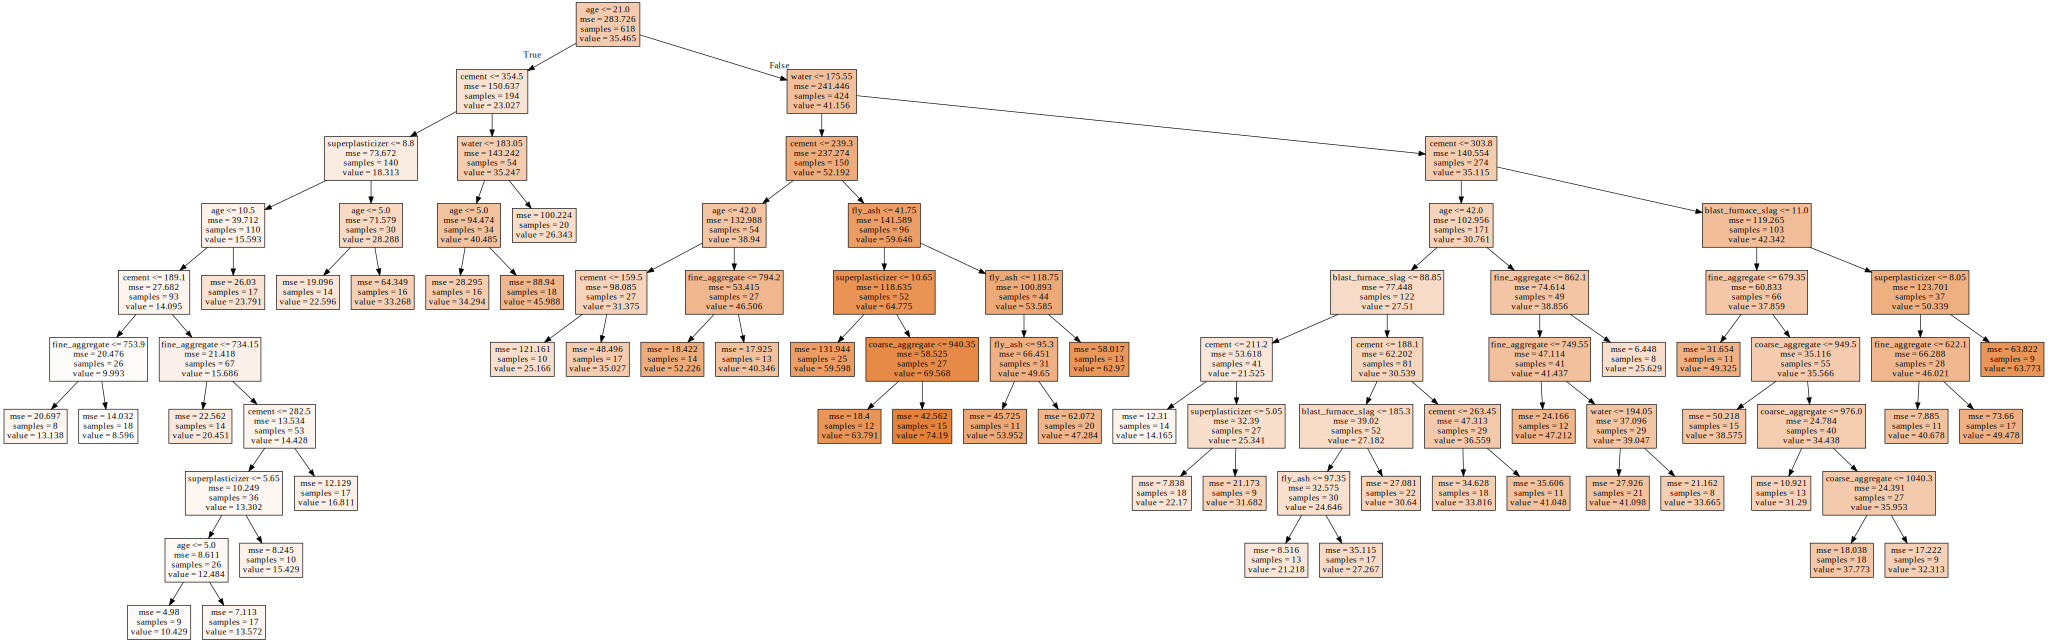

In [25]:
# 분리 노드의 최소 자료 수 = 26 모델
tree_graph=DecisionTreeRegressor(random_state=1234, min_samples_leaf=8,min_samples_split=26)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_split.dot", feature_names= v_feature_name, impurity= True, filled=True)
with open("tree_split.dot")as f:
          dot_graph=f.read()
display(graphviz.Source(dot_graph))

- 자식노드의 부모노드가 20, 26 이상이 되어야 분리가 되어 20일 경우 train의 설명력이 높아 적합하다 판단

#### 2-5. 모델 parameter 조정(max_depth)(p114)

#### - max_depth : 최대 깊이 변경에 따른 모델의 성능

In [26]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []

# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]
for v_max_depth in para_depth:
    tree=DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=20, max_depth=v_max_depth)
    
    tree.fit(df_train_x,df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

# 데이터 테이블로 저장
df_score_depth=pd.DataFrame()
df_score_depth['MinSamplesSplit'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore']= test_score

In [27]:
# 모델 설명력 확인
df_score_depth.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,1,0.249,0.243
1,2,0.474,0.406
2,3,0.644,0.567
3,4,0.749,0.680
4,5,0.822,0.734
5,6,0.862,0.787
6,7,0.876,0.801
7,8,0.882,0.801
8,9,0.882,0.802
9,10,0.882,0.802


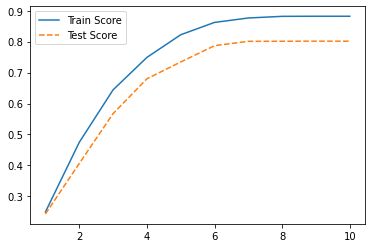

In [28]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle= "-",label="Train Score")
plt.plot(para_depth, test_score, linestyle= "--",label="Test Score")
plt.legend()

- 최대 깊이 증가에 따라 모델의 설명력은 증가한다
- train과 test의 gap차이가 작고 가장 설명력이 높은 6, 8을 채택(과대적합이 적음)

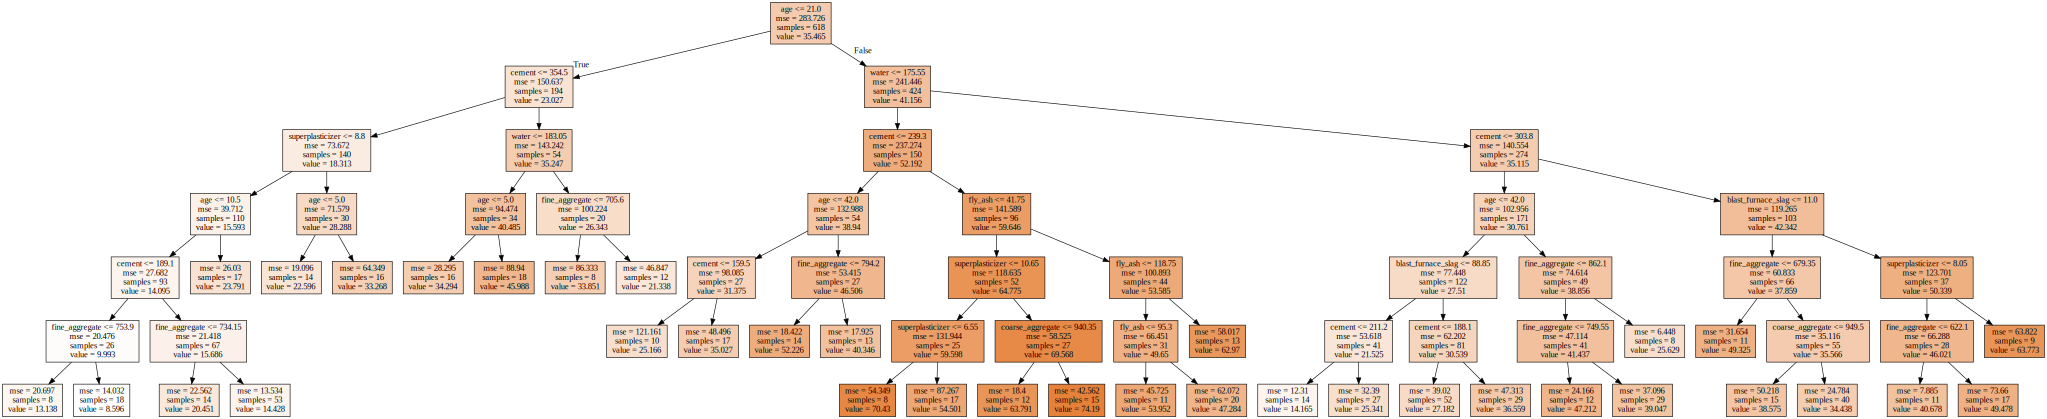

In [29]:
train_score = []; test_score = []
tree_graph=DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=20, max_depth=6)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph, out_file="tree_depth.dot", feature_names= v_feature_name, impurity= True, filled=True)
with open("tree_depth.dot")as f:
          dot_graph=f.read()
display(graphviz.Source(dot_graph))

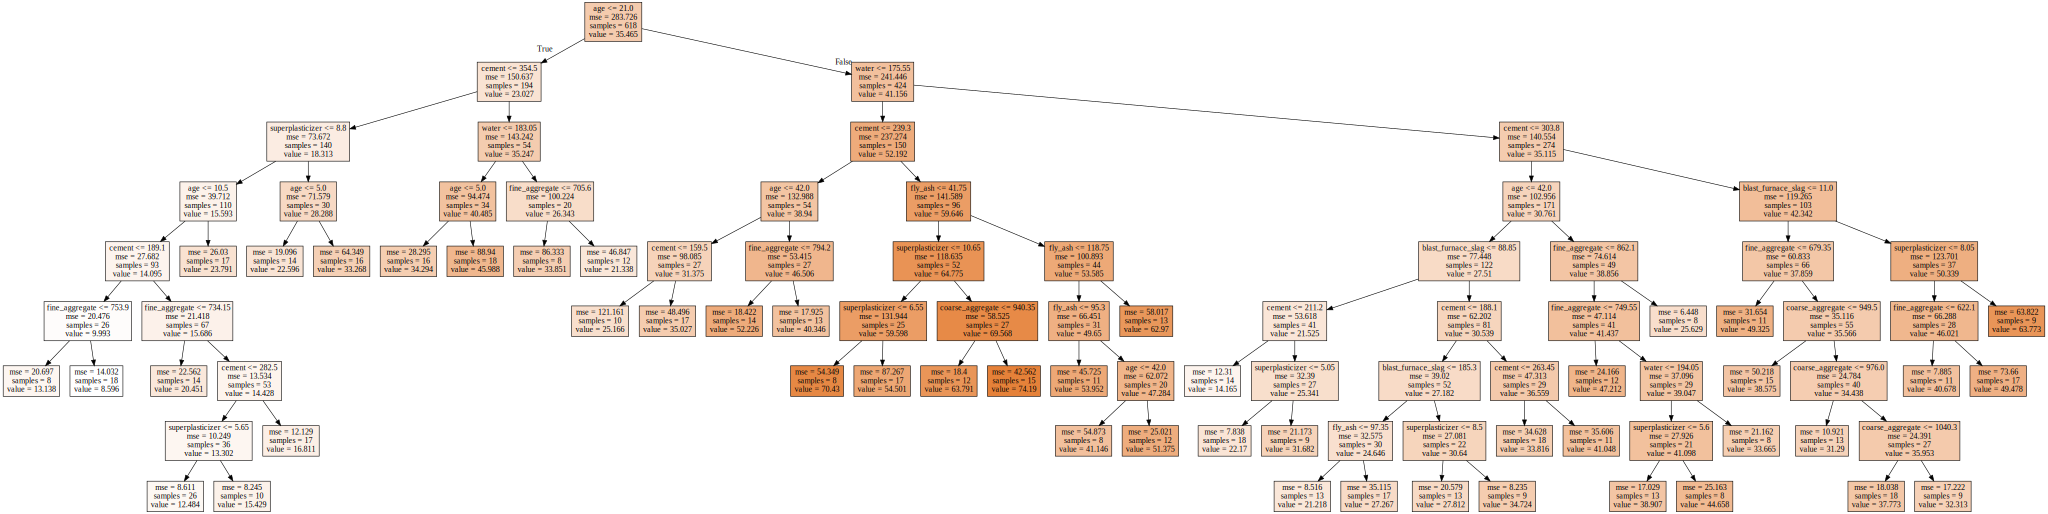

In [30]:
train_score = []; test_score = []
tree_graph=DecisionTreeRegressor(random_state=1234,min_samples_leaf=8,min_samples_split=20, max_depth=8)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph, out_file="tree_depth.dot", feature_names= v_feature_name, impurity= True, filled=True)
with open("tree_depth.dot")as f:
          dot_graph=f.read()
display(graphviz.Source(dot_graph))

- 깊이 6에서 줄일 것이라 판단

#### 3. 최종 모델 선정

#### - 최종 모델

In [31]:
tree_final=DecisionTreeRegressor(min_samples_leaf=8,min_samples_split=20, max_depth=6,random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=20,
                      random_state=1234)

#### - 최종 모델 시각화

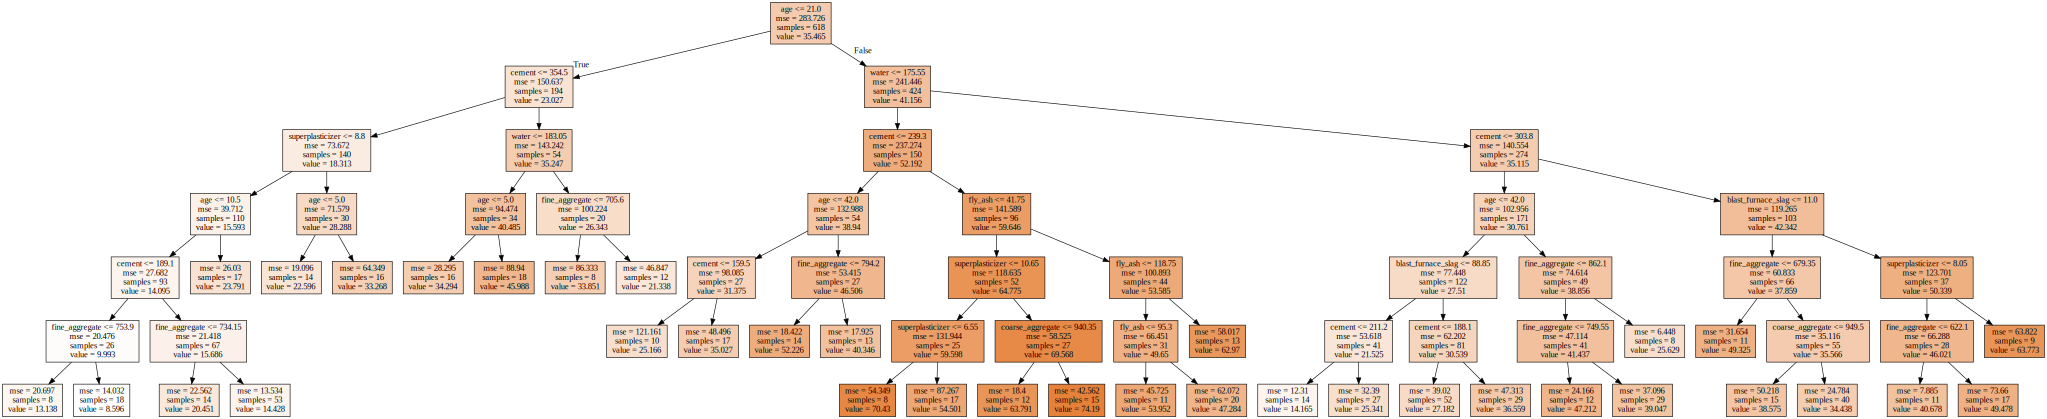

In [32]:
export_graphviz(tree_final, out_file="tree_final.dot", feature_names= v_feature_name, impurity= True, filled=True)
with open("tree_final.dot")as f:
          dot_graph=f.read()
display(graphviz.Source(dot_graph))

#### 4. 결론 도출

#### - feature_importances_ : 설명변수의 중요도

In [33]:
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["importance"]=tree_final.feature_importances_

df_importance.sort_values("importance",ascending=False , inplace=True)
df_importance.round(3)

,Feature,importance
7,age,0.362
0,cement,0.255
3,water,0.204
4,superplasticizer,0.057
6,fine_aggregate,0.044
1,blast_furnace_slag,0.039
2,fly_ash,0.033
5,coarse_aggregate,0.006


Text(0, 0.5, '변수')

C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48320 missing from current

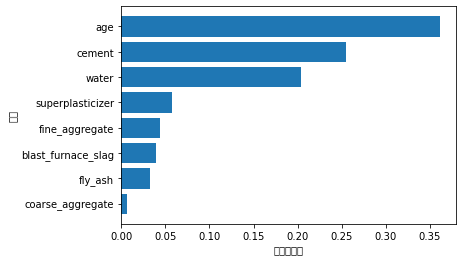

In [34]:
df_importance.sort_values("importance",ascending=True , inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수중요도")
plt.ylabel('변수')

- 중요 설명변수 : age, cement, water 순으로 영향이 크다고 할 수 있다.
- 전체적으로 다른 변수들 또한 영향력이 있음을 알 수 있다.
- 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음

#### 2. 모델 parameter 조정 - 추가

#### - GridSearchCV를 이용한 최적 parameter 찾기

In [ ]:
estimator=DecisionTreeRegressor()
param_grid={"criterion":["mse","friedman_mse","mae"],"max_features":["auto","sqrt","log2"],"max_depth": para_depth,"min_samples_split":para_split,"min_samples_leaf":para_leaf}

grid_dt=GridSearchCV(estimator,param_grid,scoring="r2",n_jobs=-1)
grid_dt.fit(df_train_x,df_train_y)

print("best estimator modle: \n{}".format(grid_dt.best_estimator_))
print("nbest parameter: \n{}".format(grid_dt.best_params_))
print("nbest score: \n{}".format(grid_dt.best_score_.round(3)))

### 2. 랜덤 포레스트

### Q 유방암 결과를 분류하는 랜덤 포레스트 모델을 만들고, predict method를 이용하여 목표변수 범주를 예측하라. 그리고 모델의 정확도와 confusion matrix를 구하여라.

#### 0. 패키지 불러오기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#### 1. 데이터 구성하기

In [2]:
df_raw = pd.read_csv('Concrete.csv',encoding='euc-kr')
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
#목표변수, 설명 변수 데이터 지정
df_raw_y = df_raw['strength']
df_raw_x = df_raw.drop('strength',axis=1,inplace=False)

In [4]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y
, test_size = 0.4, random_state = 1234)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (618, 8)
train data Y size : (618,)
test data X size : (412, 8)
test data Y size : (412,)


#### 약 train과 test의 비율을 6:4로 나누어 진행(변수는 총 8개씩 1080개)

#### 2. 모델 생성

#### - 기본 옵션으로 모델 생성

In [5]:
rf_uncustomized=RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x,df_train_y)

# train 데이터 설명
print("Score on training set:{:3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))

# test 데이터 설명
print("Score on test set:{:3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))

Score on training set:0.980068
Score on test set:0.903987


- 모델의 설명력은 train 98%, test 90.3%로 차이가 0.08정도 차이가 난다.
- (과대 적합이다)

#### - 현재 생성된 트리에 모델의 옵션 확인

In [6]:
rf_uncustomized

RandomForestRegressor(random_state=1234)

#### 2-1. 모델 parameter 조정(n_estimators)

#### 일반화 방법 1) 잎사귀 노드 수의 최소자료수 규제

#### - n_estimators : 트리 수 변경에 따른 모델 성능

In [7]:
#test 및 train 설명력 결과 저장
train_score=[];test_score=[]

# n_estimations : 트리 수 변경(1 ~ 100)
para_n_tree=[n_tree*10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf=RandomForestRegressor(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
# 결과 저장    
df_score_n=pd.DataFrame()
df_score_n["n_estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["TestScore"]=test_score

In [8]:
# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.973,0.905
1,20,0.978,0.905
2,30,0.979,0.903
3,40,0.979,0.905
4,50,0.980,0.905
5,60,0.980,0.906
6,70,0.980,0.906
7,80,0.980,0.906
8,90,0.980,0.905
9,100,0.980,0.904


- 60일 경우 값이 가장 낮은 것을 알 수 있다.(증가하는 양상은 보이지 않음)

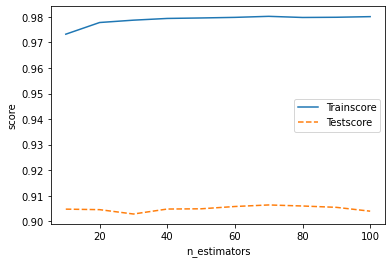

In [9]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree,train_score,linestyle="-",label="Trainscore")
plt.plot(para_n_tree,test_score,linestyle="--",label="Testscore")
plt.ylabel("score");plt.xlabel("n_estimators")
plt.legend()

- 생성하는 결정 트리 수 증가에 따라 모델의 설명력은 증가하며 트리 수가 30개를 초과해도 설명력은 거의 향상되지 않음
- 최대 트리 수에 따른 영향을 배제하고자 다른 파라미터의 영향을 확인하고자 100선택

#### 2-2. 모델 parameter 조정(min_samples_leaf)

#### - min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [10]:
# train 및 test 설명력 결과 저장
train_score=[];test_score=[]

# min_samples_leaf : 잎사귀 최소 자료 수
para_leaf=[n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestRegressor(random_state=1234,n_estimators=100,min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

# 데이터 테이블로 저장
df_score_leaf=pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

In [11]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.980,0.904
1,2,0.967,0.900
2,3,0.953,0.893
3,4,0.939,0.882
4,5,0.926,0.872
5,6,0.915,0.862
6,7,0.904,0.854
7,8,0.896,0.848
8,9,0.888,0.838
9,10,0.878,0.827


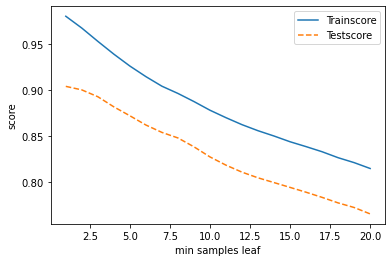

In [12]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_score,linestyle="-",label="Trainscore")
plt.plot(para_leaf,test_score,linestyle="--",label="Testscore")
plt.ylabel("score");plt.xlabel("min samples leaf")
plt.legend()

- 잎사귀의 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소하며 test 데이터의 정확도 변화를 고려하여 6을 선택

#### 일반화 방법 2) 분리노드의 최소 자료 수 변경에 따른 모델 성능

#### 2-3. 모델 parameter 조정(min_samples_split)

#### - min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [13]:
# train 및 test 설명력 결과 저장
train_score=[];test_score=[]

# min_samples_split : 분할하기 위한 노드의 최소 자료 수
para_split=[n_split*2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf=RandomForestRegressor(random_state=1234,n_estimators=100,min_samples_leaf=6 ,min_samples_split=v_min_samples_split)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

# 데이터 테이블로 저장
df_score_split=pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score

In [14]:
# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.915,0.862
1,6,0.915,0.862
2,8,0.915,0.862
3,10,0.915,0.862
4,12,0.915,0.862
5,14,0.910,0.858
6,16,0.904,0.854
7,18,0.899,0.849
8,20,0.893,0.843
9,22,0.887,0.836


- train과 test의 값의 gap이 작고 설명력이 높은 분리 노드의 최소 자료 수를 13으로 둔다.

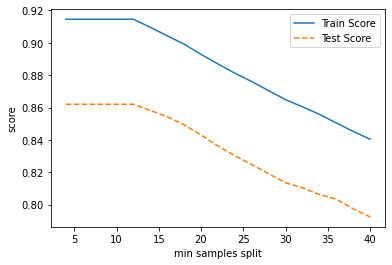

In [21]:
# 모델 설명력 그래프 확인
plt.plot(para_split,train_score,linestyle="-",label="Train Score")
plt.plot(para_split,test_score,linestyle="--",label="Test Score")
plt.ylabel("score");plt.xlabel("min samples split")
plt.legend()

#### 일반화 방법 3) 최대 깊이 변경에 따른 모델 성능

#### 2-4. 모델 parameter 조정(max_depth)

#### - max_depth : 최대 깊이 변경에 따른 모델 성능

In [19]:
# train 및 test 설명력 결과 저장
train_score=[];test_score=[]

# max_depth : 최대 깊이 변경
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf=RandomForestRegressor(random_state=1234,n_estimators=100,min_samples_leaf=6 ,min_samples_split=13,max_depth =v_max_depth)
    
    rf.fit(df_train_x,df_train_y)
    
    train_score.append(rf.score(df_train_x,df_train_y))
    
    test_score.append(rf.score(df_test_x,df_test_y))

# 데이터 테이블로 저장
df_score_depth=pd.DataFrame()
df_score_depth["Depth"]=para_split
df_score_depth["TrainScore"]=train_score
df_score_depth["TestScore"]=test_score

In [20]:
# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.337,0.329
1,2,0.619,0.595
2,3,0.742,0.699
3,4,0.817,0.775
4,5,0.872,0.828
5,6,0.896,0.850
6,7,0.907,0.857
7,8,0.911,0.860
8,9,0.912,0.860
9,10,0.912,0.860


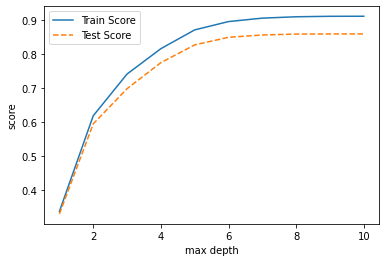

In [22]:
# 모델 설명력 그래프 확인
plt.plot(para_depth,train_score,linestyle="-",label="Train Score")
plt.plot(para_depth,test_score,linestyle="--",label="Test Score")
plt.ylabel("score");plt.xlabel("max depth")
plt.legend()

- 최대 깊이 증가에 따라 모델의 설명력은 증가하며 train과 test 데이터의 정확도 변화를 고려하여 6으로 선택

#### 3-1. 결론 도출

#### - 최종 모델 생성

In [28]:
rf_final=RandomForestRegressor(random_state=1234, n_estimators=100 , min_samples_leaf=6,min_samples_split=13,max_depth=6)

rf_final.fit(df_train_x,df_train_y)

# train 데이터 설명력
print("Score on training set:{:3f}".format(rf_final.score(df_train_x,df_train_y)))

# test 데이터 설명
print("Score on training set:{:3f}".format(rf_final.score(df_test_x,df_test_y)))

Score on training set:0.896432
Score on training set:0.850081


- train과 test의 차이가 5% 이하이므로 과적합이 해결됨을 알 수 있다.(나쁘지 않음)

#### 3-2. 결론 도출

#### - 최종 모델 시각화 : graphviz 활용

#### 0번 트리

In [36]:
# 변수명 저장
v_feature_name=df_train_x.columns

# 0번 트리
export_graphviz(rf_final.estimators_[0],out_file="rf_final_0.dot",feature_names=v_feature_name, impurity=True, filled=True)

# tree_final_0.dot 그리기
with open("rfr_final_0.dot")as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

#### 1번 트리

In [37]:
# 1번 트리
export_graphviz(rf_final.estimators_[1],out_file="rf_final_1.dot",feature_names=v_feature_name, impurity=True, filled=True)

# tree_final_0.dot 그리기
with open("rfr_final_1.dot")as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

#### 10번 트리

In [35]:
# 10번 트리
export_graphviz(rf_final.estimators_[10],out_file="rf_final_10.dot",feature_names=v_feature_name, impurity=True, filled=True)

# tree_final_0.dot 그리기
with open("rfr_final_10.dot")as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

#### 3-3. 결론 도출

#### - feature_importances_ : 설명변수의 중요도

In [33]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["importance"]=rf_final.feature_importances_

# df_feature_importantce의 테이블을 중요도 순으로 정렬
df_importance.sort_values("importance",ascending=False , inplace=True)
df_importance.round(3)

,Feature,importance
7,age,0.378
0,cement,0.277
3,water,0.152
4,superplasticizer,0.082
1,blast_furnace_slag,0.044
6,fine_aggregate,0.037
5,coarse_aggregate,0.016
2,fly_ash,0.014


- age의 중요도가 가장 큼을 알 수 있다.

Text(0, 0.5, '변수')

C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48320 missing from current

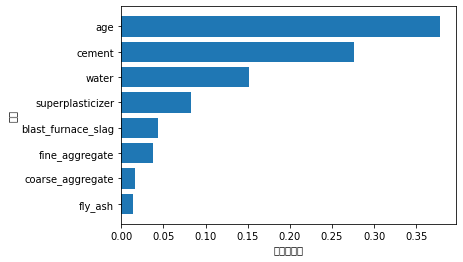

In [34]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("importance",ascending=True , inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates,width=df_importance["importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수중요도")
plt.ylabel('변수')

#### 중요 설명변수 : age, cement, water순으로 영향이 크다고 할 수 있다.
(단,계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음)

#### 2-5. 모델 parameter 조정 - 추가

#### - GridSearchCV를 이용한 최적 parameter 찾기

In [24]:
estimator=DecisionTreeRegressor(random_state=1234)

# 구하고자 하는 parameter와 범위
param_grid={"max_depth": para_depth,"min_samples_split":para_split,"min_samples_leaf": para_leaf}

# 설명력이 높은 최적의 parameter 찾기
grid_dt=GridSearchCV(estimator,param_grid,scoring="r2",n_jobs=-1)
grid_dt.fit(df_train_x,df_train_y)

print("best estimator modle: \n{}".format(grid_dt.best_estimator_))
print("nbest parameter: \n{}".format(grid_dt.best_params_))
print("nbest score: \n{}".format(grid_dt.best_score_.round(3)))

NameError: name 'para_depth' is not defined

### 3. 그래디언트 부스팅

#### Q 콘크리트 강도를 예측하는 그래드언트 부스팅 모델을 만들고 predict method를 이용하여 예측값을 구하여라.

#### 0. 패키지 불러오기

In [2]:
#데이터 처리
import pandas as pd

# 행렬 연산
import numpy as np

# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 회귀 분석
from statsmodels.formula.api import ols

# qqplot,회귀 분석의 상수항 추가
from statsmodels.api import qqplot,add_constant

#선형 모델 formula(y~ X1 + X2+...)
import statsmodels.formula.api as smf

# 평가함수
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# 다중 공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

#학습용/평가용 데이터 분리: train,test
from sklearn.model_selection import train_test_split

# 선형 회귀모형
from sklearn.linear_model import LinearRegression

# 변수 선택법(후진 제거법)
from sklearn.feature_selection import RFE

# 표준화 회귀 계수 산출
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV 

#### 1. 데이터 구성하기

In [4]:
df_raw = pd.read_csv("Concrete.csv")

df_raw_y = df_raw["strength"]
df_raw_x = df_raw.drop("strength",axis=1, inplace=False)

In [7]:
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size=0.4,random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (618, 8)
train data Y size: (618,)
test data X size: (412, 8)
test data Y size: (412,)


#### 2-1. 모델 생성

#### - 기본 옵션으로 모델 생성

In [9]:
# 모델 생성 : GradientBoostingRegressor
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x,df_train_y)

# train 데이터 설명력
print("Score on training set:{:.3f}".format(gb_uncustomized.score(df_train_x,df_train_y)))

# test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score(df_test_x,df_test_y)))

Score on training set:0.951
Score on test set: 0.915


- 모델 설명력은 train 95.1%, test 91.5%로 모델은 train 데이터에 과대적합
- (train과 test의 값이 비슷할수록 좋은모델이다.)

#### - 현재 생성된 트리 모델의 옵션 확인

In [10]:
gb_uncustomized

GradientBoostingRegressor(random_state=1234)

#### 2-2. 모델 생성

#### - n_estimators : 트리 수 변경에 따른 모델 성능

In [11]:
# train 및 test 설명력 결과 저장
train_score = []; test_score= []

# n_estimators : 트리 수 변경(10~100)
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state =1234, n_estimators = v_n_estimators)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x,df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["Estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

In [12]:
# 모델 설명력 확인
df_score_n.round(3)

,Estimators,TrainScore,TestScore
0,10,0.646,0.621
1,20,0.807,0.773
2,30,0.870,0.835
3,40,0.898,0.863
4,50,0.915,0.878
5,60,0.925,0.888
6,70,0.934,0.898
7,80,0.940,0.904
8,90,0.946,0.910
9,100,0.951,0.915


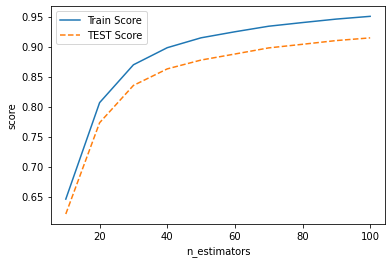

In [13]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree,train_score,linestyle="-",label="Train Score")
plt.plot(para_n_tree,test_score,linestyle="--",label = "TEST Score")
plt.ylabel("score");plt.xlabel("n_estimators")
plt.legend()

- 트리 수 증가에 따라 모델의 설명력은 증가하고 있으나 test 데이터의 성능 변화를 고려하여 40을 기준으로 train과 test의 값의 차이가 나지 않는다. 성능이 좋음을 의미
#### - 결론 : 과대적합이 일어나지 않는 곳인 트리 수 40으로 선정

#### 2-3. 모델 생성(입사귀노드법)

In [14]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []

# min_samples_leaf : 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = GradientBoostingRegressor(random_state=1234,n_estimators= 40,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))

# 결과 저장
df_score_leaf =pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [15]:
# 모델 설명력 확인
print(df_score_leaf.round(3))

    MinSamplesLeaf  TrainScore  TestScore
0                1       0.898      0.863
1                2       0.898      0.863
2                3       0.896      0.861
3                4       0.897      0.864
4                5       0.895      0.864
5                6       0.895      0.865
6                7       0.894      0.865
7                8       0.895      0.865
8                9       0.894      0.866
9               10       0.892      0.864
10              11       0.894      0.865
11              12       0.894      0.862
12              13       0.894      0.861
13              14       0.891      0.866
14              15       0.890      0.862
15              16       0.887      0.861
16              17       0.888      0.860
17              18       0.887      0.858
18              19       0.889      0.861
19              20       0.886      0.859


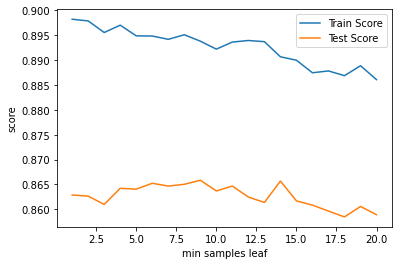

In [16]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf,train_score,linestyle="-",label="Train Score")
plt.plot(para_leaf,test_score,linestyle="-",label="Test Score")
plt.ylabel("score");plt.xlabel("min samples leaf")
plt.legend()

- 잎사귀 노드의 최소 자료 수의 증가에 따라 모델의 설명력은 감소하며 test데이터가 10과 14에서 좋은 성능이 나타남.
#### - 결론 : 성능변화를 고려하여 10으로 결정

#### 2-3. 모델 생성(min_samples_split)

#### - min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [17]:
# train 및 test 설명력 결과 저장
train_score =[]; test_score = []

# min_samples_split : 분할하기 위한 노드의 최소 자료 수
para_split = [n_split *2 for n_split in range(1,21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234,n_estimators=40,
                                min_samples_leaf = 9
                                ,min_samples_split = v_min_samples_split)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x,df_test_y))

# 결과 저장
df_score_split =pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.894,0.866
1,4,0.894,0.866
2,6,0.894,0.866
3,8,0.894,0.866
4,10,0.894,0.866
5,12,0.894,0.866
6,14,0.894,0.866
7,16,0.894,0.866
8,18,0.894,0.866
9,20,0.894,0.868


- 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소하며 test, train 데이터의 성능 변화를 고려했을 때 min_samples_split은 20에서 가장 높은 성능을 나타냄.

#### 2-4. 모델 생성(max_depth)

#### - max_depth : 최대 깊이 변경에 따른 모델 성능(크기의 개수에 따라 판단)

In [19]:
# train 및 test 설명력 결과 저장
train_score =[]; test_score = []

# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234,
                                min_samples_leaf = 9
                                ,n_estimators=40
                                ,min_samples_split = 20,
                                 max_depth = v_max_depth)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x,df_test_y))

# 결과 저장
df_score_depth =pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.669,0.645
1,2,0.838,0.809
2,3,0.894,0.868
3,4,0.930,0.891
4,5,0.952,0.901
5,6,0.962,0.915
6,7,0.970,0.920
7,8,0.973,0.918
8,9,0.975,0.921
9,10,0.975,0.920


In [20]:
# 모델의 설명력
print(df_score_depth.round(3))

   Depth  TrainScore  TestScore
0      1       0.669      0.645
1      2       0.838      0.809
2      3       0.894      0.868
3      4       0.930      0.891
4      5       0.952      0.901
5      6       0.962      0.915
6      7       0.970      0.920
7      8       0.973      0.918
8      9       0.975      0.921
9     10       0.975      0.920


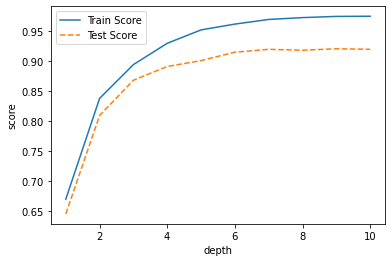

In [22]:
# 모델 설명력 그래프 확인 : 4단계
plt.plot(para_depth,train_score,linestyle="-",label = "Train Score")
plt.plot(para_depth,test_score,linestyle="--",label = "Test Score")
plt.ylabel("score");plt.xlabel("depth")
plt.legend()

- 최대 깊이 증가에 따라 모델의 설명력은 증가하고 4~5가 가장 이상적인 것으로 판단.test 데이터가 4에서 과적합성이 낮음

#### 2-5. 모델 생성(learning_rate)

#### - learning_rate : 학습률 변경에 따른 모델 성능

In [25]:
# train 및 test 설명력 결과 저장
train_score =[]; test_score = []

# learning rate : 학습률 변경(0.1 ~ 0.9)
para_lr = [lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234,
                                min_samples_leaf = 9
                                ,n_estimators=40
                                ,min_samples_split = 20,
                                 max_depth = 4,
                                  learning_rate=v_learning_rate)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    test_score.append(gb.score(df_test_x,df_test_y))

# 결과 저장
df_score_lr =pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.930,0.891
1,0.2,0.959,0.917
2,0.3,0.968,0.914
3,0.4,0.971,0.912
4,0.5,0.974,0.910
5,0.6,0.977,0.906
6,0.7,0.977,0.897
7,0.8,0.982,0.891
8,0.9,0.981,0.885


In [26]:
# 모델 설명력 확인
print(df_score_lr.round(3))

   LearningRate  TrainScore  TestScore
0           0.1       0.930      0.891
1           0.2       0.959      0.917
2           0.3       0.968      0.914
3           0.4       0.971      0.912
4           0.5       0.974      0.910
5           0.6       0.977      0.906
6           0.7       0.977      0.897
7           0.8       0.982      0.891
8           0.9       0.981      0.885


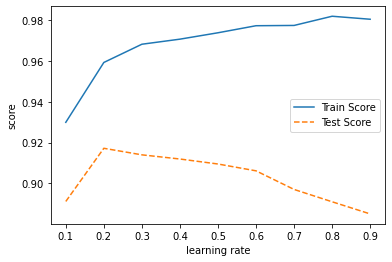

In [27]:
# 모델 설명력 그래프 확인
plt.plot(para_lr,train_score,linestyle="-",label = "Train Score")
plt.plot(para_lr,test_score,linestyle="--",label = "Test Score")
plt.ylabel("score");plt.xlabel("learning rate")
plt.legend()

- test 데이터의 성능은 급격하게 저하되는 0.2지점 선택
- 학습률 증가에 따라 모델의 설명력은 증가한다.
#### - 결론 : 0.2가 가장 적합하다고 판단

#### 3. 결론 도출

#### - 최종 모델 생성

In [28]:
gb_final = GradientBoostingRegressor(random_state = 1234, min_samples_leaf = 11,n_estimators=30, min_samples_split = 22, max_depth = 4,learning_rate=0.1)
gb_final.fit(df_train_x,df_train_y)

# train 데이터 설명력
print("Score on training set:{:.3f}".format(gb_final.score(df_train_x,df_train_y)))

# test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x,df_test_y)))

Score on training set:0.913
Score on test set: 0.876


- test와 train 데이터의 차이가 약 0.04정도 차이가 난다.
#### - 결론 : 과대적합하지 않다고 판단

#### - feature_importances_: 설명변수의 중요도

In [29]:
# 변수명 저장
v_feature_name= df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance",ascending = False, inplace =True)
df_importance.round(3)

,Feature,Importance
7,age,0.362
0,cement,0.289
3,water,0.132
4,superplasticizer,0.092
1,blast_furnace_slag,0.062
6,fine_aggregate,0.038
5,coarse_aggregate,0.013
2,fly_ash,0.010


#### - 결론 : age와 cement의 변수 중요도가 가장 높다고 판단을 선정

Text(0, 0.5, '변수')

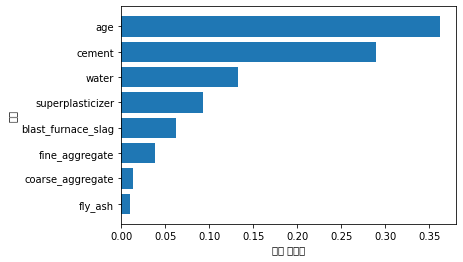

In [31]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance",ascending = True, inplace =True)
coordinates =range(len(df_importance))
plt.barh(y= coordinates,width =df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### - 결론 :  중요설명변수 : age, cement, water순으로 영향이 크다고 해석할 수 있음
####  단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있음